# Sim-Real Comparison Across Three Segments (Publication Style)

This notebook performs **three-segment** simulation-vs-experiment validation for fixed datasets:
- Segment 1: \(\theta_0 \approx 49.88^\circ\) *(in-sample)*
- Segment 2: \(\theta_0 \approx 30.87^\circ\) *(out-of-sample)*
- Segment 3: \(\theta_0 \approx 2.05^\circ\) *(out-of-sample)*

All results are rendered **in-notebook only** (`plt.show()` / `display()`), with **no file export**.


In [1]:
from __future__ import annotations

import math
import sys
import warnings
from dataclasses import dataclass
from pathlib import Path
from typing import Optional

import importlib
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from scipy.interpolate import interp1d
from IPython.display import display

# --- repo bootstrap ---
_CWD = Path.cwd().resolve()
REPO_ROOT = None
for p in [_CWD, *_CWD.parents]:
    if (p / 'sim_flip').is_dir():
        REPO_ROOT = p
        break
if REPO_ROOT is None:
    raise FileNotFoundError(f'Cannot find repo root containing sim_flip/; cwd={_CWD}')
if str(REPO_ROOT) not in sys.path:
    sys.path.insert(0, str(REPO_ROOT))

import sim_flip.src.dynamics as dynamics  # noqa: E402
importlib.reload(dynamics)
simulate = dynamics.simulate

warnings.filterwarnings('ignore', category=UserWarning)


In [2]:
# --- publication-style global plot settings ---

mpl.rcParams.update({
    'figure.dpi': 150,
    'savefig.dpi': 600,
    'font.family': 'serif',
    'font.serif': ['Times New Roman', 'STIXGeneral', 'DejaVu Serif', 'serif'],
    'mathtext.fontset': 'stix',
    'font.size': 9,
    'axes.labelsize': 9,
    'axes.titlesize': 9,
    'axes.linewidth': 0.8,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'axes.grid': True,
    'axes.axisbelow': True,
    'grid.alpha': 0.25,
    'grid.linewidth': 0.5,
    'grid.linestyle': '-',
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'xtick.major.width': 0.8,
    'ytick.major.width': 0.8,
    'legend.frameon': False,
    'legend.fontsize': 8,
    'lines.linewidth': 1.3,
})

COLORS = {
    'exp': '#4D4D4D',      # dark gray
    'seg1': '#0072B2',     # blue
    'seg2': '#D55E00',     # vermillion
    'seg3': '#009E73',     # green
    'target': '#CC79A7',   # magenta
}

SEGMENT_ORDER = ['Segment 1', 'Segment 2', 'Segment 3']
SEGMENT_FILES = {
    'Segment 1': 'Segment_1_Target_49_9_start_32.25s_theta_49.88deg_end_75s.csv',
    'Segment 2': 'Segment_2_Target_31_0_start_95.30s_theta_30.87deg_end_130s.csv',
    'Segment 3': 'Segment_3_Target_2_5_start_150.79s_theta_2.05deg_end_190s.csv',
}
VALIDATION_TAG = {
    'Segment 1': 'in-sample',
    'Segment 2': 'out-of-sample',
    'Segment 3': 'out-of-sample',
}
SEGMENT_COLOR = {
    'Segment 1': COLORS['seg1'],
    'Segment 2': COLORS['seg2'],
    'Segment 3': COLORS['seg3'],
}

TARGET_THETA_DEG = 90.0
STEADY_STATE_RATIO = 0.2
PLOT_DECIMATE_MAX_POINTS = 2000

SCORE_WEIGHTS = {
    'N_RMSE_theta': 0.35,
    'N_MAE_theta': 0.20,
    'N_RMSE_q': 0.20,
    'N_t90': 0.15,
    'N_over': 0.10,
}

PARAMS_PATH = (REPO_ROOT / 'sim_flip' / 'configs' / 'params_nominal.yaml').resolve()
DATA_DIR = (REPO_ROOT / 'sim_flip' / 'data').resolve()


In [3]:
@dataclass
class SegmentRun:
    segment: str
    tag: str
    csv_path: Path
    success: bool
    message: str
    exp: pd.DataFrame
    sim: pd.DataFrame


def first_crossing_time(t: np.ndarray, y: np.ndarray, threshold: float) -> float:
    """Time of first upward crossing of threshold using linear interpolation."""
    idx = np.where(y >= threshold)[0]
    if len(idx) == 0:
        return float('nan')
    i = int(idx[0])
    if i == 0:
        return float(t[0])
    t0, t1 = float(t[i - 1]), float(t[i])
    y0, y1 = float(y[i - 1]), float(y[i])
    if y1 == y0:
        return t1
    return t0 + (threshold - y0) * (t1 - t0) / (y1 - y0)


def decimate_indices(n: int, max_points: int) -> np.ndarray:
    if n <= max_points:
        return np.arange(n, dtype=int)
    step = int(math.ceil(n / max_points))
    idx = np.arange(0, n, step, dtype=int)
    if idx[-1] != n - 1:
        idx = np.concatenate([idx, np.array([n - 1], dtype=int)])
    return idx


def load_segment_from_csv(path: Path) -> pd.DataFrame:
    df = pd.read_csv(path)
    df.columns = [str(c).strip() for c in df.columns]
    lower = {c.lower(): c for c in df.columns}

    def _find(keys: list[str]) -> Optional[str]:
        for k in keys:
            if k.lower() in lower:
                return lower[k.lower()]
        return None

    tcol = _find(['Time_rel_s', 'Time_s', 'time', 't'])
    if tcol is None:
        raise ValueError(f'{path.name}: missing time column; columns={df.columns.tolist()}')

    th_deg_col = _find(['Theta_filt_deg', 'theta_deg', 'theta'])
    th_rad_col = _find(['Theta_filt_rad', 'theta_rad'])
    if th_deg_col is None and th_rad_col is None:
        raise ValueError(f'{path.name}: missing theta column; columns={df.columns.tolist()}')

    q_rad_col = _find(['q_filt_rad', 'q_rad_s', 'q_rad', 'q'])
    q_deg_col = _find(['q_filt_deg', 'q_deg_s', 'q_deg'])

    t = pd.to_numeric(df[tcol], errors='coerce').to_numpy(dtype=float)
    if th_deg_col is not None:
        theta_deg = pd.to_numeric(df[th_deg_col], errors='coerce').to_numpy(dtype=float)
    else:
        theta_deg = np.degrees(pd.to_numeric(df[th_rad_col], errors='coerce').to_numpy(dtype=float))

    out = pd.DataFrame({'t': t, 'theta_deg': theta_deg})

    if q_rad_col is not None:
        out['q_rad_s'] = pd.to_numeric(df[q_rad_col], errors='coerce').to_numpy(dtype=float)
    elif q_deg_col is not None:
        out['q_rad_s'] = np.radians(pd.to_numeric(df[q_deg_col], errors='coerce').to_numpy(dtype=float))

    out = out.replace([np.inf, -np.inf], np.nan).dropna(subset=['t', 'theta_deg']).sort_values('t').reset_index(drop=True)
    out['t'] = out['t'] - float(out['t'].iloc[0])
    return out


def run_segment_sim(segment: str, csv_path: Path, tag: str) -> SegmentRun:
    exp = load_segment_from_csv(csv_path)
    if exp.empty:
        raise ValueError(f'{csv_path.name}: empty experimental segment after cleaning')

    theta0_deg = float(exp['theta_deg'].iloc[0])
    t_end = float(exp['t'].iloc[-1])

    result = simulate(
        y0=[0.0, 0.0, 0.0, np.deg2rad(theta0_deg)],
        params_path=PARAMS_PATH,
        t_span=(0.0, t_end),
        dt_out=0.01,
    )

    sim = result.data.copy() if result.success else pd.DataFrame()
    return SegmentRun(
        segment=segment,
        tag=tag,
        csv_path=csv_path,
        success=bool(result.success),
        message=str(result.message),
        exp=exp,
        sim=sim,
    )


def compute_gap_metrics(run: SegmentRun) -> dict:
    if not run.success:
        return {
            'segment': run.segment,
            'validation': run.tag,
            'csv_file': run.csv_path.name,
            'success': False,
            'message': run.message,
        }

    exp = run.exp
    sim = run.sim

    t_exp = exp['t'].to_numpy(dtype=float)
    th_exp = exp['theta_deg'].to_numpy(dtype=float)

    t_sim = sim['t'].to_numpy(dtype=float)
    th_sim = sim['theta_deg'].to_numpy(dtype=float)

    interp_theta = interp1d(t_sim, th_sim, kind='linear', bounds_error=False, fill_value='extrapolate')
    th_sim_aligned = interp_theta(t_exp)

    err_th = th_sim_aligned - th_exp
    rmse_th = float(np.sqrt(np.mean(err_th ** 2)))
    mae_th = float(np.mean(np.abs(err_th)))
    max_abs_th = float(np.max(np.abs(err_th)))

    duration = float(t_exp[-1] - t_exp[0])
    if duration > 1e-12:
        dt = np.diff(t_exp)
        err_abs_mid = 0.5 * (np.abs(err_th[1:]) + np.abs(err_th[:-1]))
        err_mid = 0.5 * (err_th[1:] + err_th[:-1])
        taae_th = float(np.sum(err_abs_mid * dt) / duration)
        tase_th = float(np.sum(err_mid * dt) / duration)
    else:
        taae_th = mae_th
        tase_th = float(np.mean(err_th))

    t80_sim = first_crossing_time(t_sim, th_sim, 80.0)
    t80_exp = first_crossing_time(t_exp, th_exp, 80.0)
    t90_sim = first_crossing_time(t_sim, th_sim, 90.0)
    t90_exp = first_crossing_time(t_exp, th_exp, 90.0)

    theta_max_sim = float(np.max(th_sim))
    theta_max_exp = float(np.max(th_exp))
    overshoot_error = theta_max_sim - theta_max_exp

    n_ss = max(1, int(STEADY_STATE_RATIO * len(t_exp)))
    ss_sim = th_sim_aligned[-n_ss:]
    ss_exp = th_exp[-n_ss:]
    ss_mean_error = float(np.mean(ss_sim) - np.mean(ss_exp))
    ss_std_sim = float(np.std(ss_sim))
    ss_std_exp = float(np.std(ss_exp))

    q_rmse = float('nan')
    q_mae = float('nan')
    q_scale_p95 = float('nan')
    if 'q_rad_s' in exp.columns and 'q' in sim.columns:
        q_exp = exp['q_rad_s'].to_numpy(dtype=float)
        q_sim = sim['q'].to_numpy(dtype=float)
        interp_q = interp1d(t_sim, q_sim, kind='linear', bounds_error=False, fill_value='extrapolate')
        q_sim_aligned = interp_q(t_exp)
        q_err = q_sim_aligned - q_exp
        q_rmse = float(np.sqrt(np.mean(q_err ** 2)))
        q_mae = float(np.mean(np.abs(q_err)))
        q_scale_p95 = float(np.percentile(np.abs(q_exp), 95))

    return {
        'segment': run.segment,
        'validation': run.tag,
        'csv_file': run.csv_path.name,
        'success': True,
        'message': run.message,
        'theta0_deg': float(th_exp[0]),
        'duration_s': float(t_exp[-1] - t_exp[0]),
        'RMSE_theta_deg': rmse_th,
        'MAE_theta_deg': mae_th,
        'TAAE_theta_deg': taae_th,
        'TASE_theta_deg': tase_th,
        'MaxAbs_theta_deg': max_abs_th,
        't80_sim_s': t80_sim,
        't80_exp_s': t80_exp,
        'dt80_s': t80_sim - t80_exp if not (np.isnan(t80_sim) or np.isnan(t80_exp)) else float('nan'),
        't90_sim_s': t90_sim,
        't90_exp_s': t90_exp,
        'dt90_s': t90_sim - t90_exp if not (np.isnan(t90_sim) or np.isnan(t90_exp)) else float('nan'),
        'theta_max_sim_deg': theta_max_sim,
        'theta_max_exp_deg': theta_max_exp,
        'overshoot_error_deg': overshoot_error,
        'SS_mean_error_deg': ss_mean_error,
        'SS_std_sim_deg': ss_std_sim,
        'SS_std_exp_deg': ss_std_exp,
        'RMSE_q_rad_s': q_rmse,
        'MAE_q_rad_s': q_mae,
        'q_scale_p95': q_scale_p95,
    }


def compute_normalized_metrics(row: pd.Series, eps: float = 1e-6) -> dict:
    theta_span = max(abs(TARGET_THETA_DEG - float(row['theta0_deg'])), eps)

    n_rmse_theta = float(row['RMSE_theta_deg']) / theta_span
    n_mae_theta = float(row['MAE_theta_deg']) / theta_span
    n_taae_theta = float(row['TAAE_theta_deg']) / theta_span
    n_over = abs(float(row['overshoot_error_deg'])) / theta_span

    n_t = float('nan')
    if np.isfinite(row['dt90_s']) and np.isfinite(row['t90_exp_s']) and float(row['t90_exp_s']) > eps:
        n_t = abs(float(row['dt90_s'])) / float(row['t90_exp_s'])
    elif np.isfinite(row['dt80_s']) and np.isfinite(row['t80_exp_s']) and float(row['t80_exp_s']) > eps:
        n_t = abs(float(row['dt80_s'])) / float(row['t80_exp_s'])

    n_rmse_q = float('nan')
    if np.isfinite(row['RMSE_q_rad_s']):
        q_scale = max(float(row['q_scale_p95']) if np.isfinite(row['q_scale_p95']) else eps, eps)
        n_rmse_q = float(row['RMSE_q_rad_s']) / q_scale

    return {
        'N_RMSE_theta': n_rmse_theta,
        'N_MAE_theta': n_mae_theta,
        'N_TAAE_theta': n_taae_theta,
        'N_RMSE_q': n_rmse_q,
        'N_t90': n_t,
        'N_over': n_over,
    }


def compute_gap_score(norm_row: pd.Series) -> float:
    terms = []
    weights = []
    for key, w in SCORE_WEIGHTS.items():
        val = norm_row.get(key, np.nan)
        if np.isfinite(val):
            terms.append(float(val))
            weights.append(float(w))

    if not terms:
        return float('nan')

    wsum = float(np.sum(weights))
    return float(np.dot(np.array(terms), np.array(weights) / wsum))


def _panel_label(ax: plt.Axes, label: str) -> None:
    ax.text(0.01, 0.98, label, transform=ax.transAxes, ha='left', va='top',
            fontsize=10, fontweight='bold')


def plot_main_figure(runs_by_segment: dict[str, SegmentRun], metrics_df: pd.DataFrame) -> None:
    fig, axes = plt.subplots(3, 2, figsize=(10.8, 8.6), squeeze=False)
    panel_labels = ['A', 'B', 'C', 'D', 'E', 'F']
    pidx = 0

    for r, segment in enumerate(SEGMENT_ORDER):
        ax_th = axes[r, 0]
        ax_q = axes[r, 1]
        _panel_label(ax_th, panel_labels[pidx]); pidx += 1
        _panel_label(ax_q, panel_labels[pidx]); pidx += 1

        if segment not in runs_by_segment:
            ax_th.text(0.5, 0.5, f'{segment}: simulation failed', transform=ax_th.transAxes, ha='center', va='center')
            ax_q.text(0.5, 0.5, f'{segment}: simulation failed', transform=ax_q.transAxes, ha='center', va='center')
            continue

        run = runs_by_segment[segment]
        row = metrics_df.loc[metrics_df['segment'] == segment].iloc[0]

        exp = run.exp
        sim = run.sim

        idx_exp = decimate_indices(len(exp), PLOT_DECIMATE_MAX_POINTS)
        idx_sim = decimate_indices(len(sim), PLOT_DECIMATE_MAX_POINTS)

        ax_th.plot(exp['t'].to_numpy()[idx_exp], exp['theta_deg'].to_numpy()[idx_exp],
                   color=COLORS['exp'], linestyle='-', linewidth=1.1, alpha=0.95, label='Experiment')
        ax_th.plot(sim['t'].to_numpy()[idx_sim], sim['theta_deg'].to_numpy()[idx_sim],
                   color=SEGMENT_COLOR[segment], linestyle='--', linewidth=1.4, label='Simulation')
        ax_th.axhline(TARGET_THETA_DEG, color=COLORS['target'], linestyle=':', linewidth=1.0, alpha=0.8)

        ax_th.set_ylabel(r'Pitch angle $\theta$ (deg)')
        ax_th.set_title(f"{segment} ({VALIDATION_TAG[segment]}), "
                        f"$\theta_0={row['theta0_deg']:.2f}^\circ$")
        ax_th.set_xlim(0.0, float(exp['t'].iloc[-1]))

        dt90_txt = f"{row['dt90_s']:+.2f}s" if np.isfinite(row['dt90_s']) else 'N/A'
        box_text = f"RMSE={row['RMSE_theta_deg']:.2f}?\nMAE={row['MAE_theta_deg']:.2f}?\nTAAE={row['TAAE_theta_deg']:.2f}?\n?t90={dt90_txt}"
        ax_th.text(0.98, 0.96, box_text, transform=ax_th.transAxes, ha='right', va='top', fontsize=7,
                   bbox=dict(boxstyle='round,pad=0.25', fc='white', ec='0.8', alpha=0.95))

        if 'q_rad_s' in exp.columns and 'q' in sim.columns:
            ax_q.plot(exp['t'].to_numpy()[idx_exp], exp['q_rad_s'].to_numpy()[idx_exp],
                      color=COLORS['exp'], linestyle='-', linewidth=1.1, alpha=0.95, label='Experiment')
            ax_q.plot(sim['t'].to_numpy()[idx_sim], sim['q'].to_numpy()[idx_sim],
                      color=SEGMENT_COLOR[segment], linestyle='--', linewidth=1.4, label='Simulation')

            rmse_q_txt = f"{row['RMSE_q_rad_s']:.3f}" if np.isfinite(row['RMSE_q_rad_s']) else 'N/A'
            mae_q_txt = f"{row['MAE_q_rad_s']:.3f}" if np.isfinite(row['MAE_q_rad_s']) else 'N/A'
            q_box = f"RMSE_q={rmse_q_txt}\nMAE_q={mae_q_txt}\nTAAE={row['TAAE_theta_deg']:.2f}?\n?t90={dt90_txt}"
            ax_q.text(0.98, 0.96, q_box, transform=ax_q.transAxes, ha='right', va='top', fontsize=7,
                      bbox=dict(boxstyle='round,pad=0.25', fc='white', ec='0.8', alpha=0.95))
        else:
            ax_q.text(0.5, 0.5, 'q data unavailable', transform=ax_q.transAxes, ha='center', va='center')

        ax_q.axhline(0.0, color='0.6', linestyle=':', linewidth=0.8)
        ax_q.set_ylabel(r'Pitch rate $q$ (rad/s)')
        ax_q.set_xlim(0.0, float(exp['t'].iloc[-1]))

        if r == 0:
            ax_th.legend(loc='upper left', ncol=2)
            ax_q.legend(loc='upper left', ncol=2)

    axes[-1, 0].set_xlabel('Time (s)')
    axes[-1, 1].set_xlabel('Time (s)')
    fig.suptitle('Figure 1. Multi-segment Sim-Real Comparison', y=0.995, fontsize=10)
    fig.tight_layout()
    plt.show()


def plot_error_figure(runs_by_segment: dict[str, SegmentRun], metrics_df: pd.DataFrame) -> None:
    fig, axes = plt.subplots(3, 1, figsize=(10.8, 6.8), squeeze=False)
    axes = axes.flatten()

    for i, segment in enumerate(SEGMENT_ORDER):
        ax = axes[i]
        if segment not in runs_by_segment:
            ax.text(0.5, 0.5, f'{segment}: simulation failed', transform=ax.transAxes, ha='center', va='center')
            continue

        run = runs_by_segment[segment]
        row = metrics_df.loc[metrics_df['segment'] == segment].iloc[0]

        t_exp = run.exp['t'].to_numpy(dtype=float)
        th_exp = run.exp['theta_deg'].to_numpy(dtype=float)

        t_sim = run.sim['t'].to_numpy(dtype=float)
        th_sim = run.sim['theta_deg'].to_numpy(dtype=float)

        interp_theta = interp1d(t_sim, th_sim, kind='linear', bounds_error=False, fill_value='extrapolate')
        th_sim_aligned = interp_theta(t_exp)
        err = th_sim_aligned - th_exp

        idx = decimate_indices(len(t_exp), PLOT_DECIMATE_MAX_POINTS)
        t_plot = t_exp[idx]
        err_plot = err[idx]

        rmse = float(row['RMSE_theta_deg'])
        ax.fill_between(t_plot, -rmse, rmse, color='0.85', alpha=0.7, label='?RMSE band')
        ax.plot(t_plot, err_plot, color=SEGMENT_COLOR[segment], linewidth=1.2, label=r'$e_\theta(t)$')
        ax.axhline(0.0, color='0.35', linestyle='--', linewidth=0.9)

        ax.set_xlim(0.0, float(t_exp[-1]))
        ax.set_ylabel(r'Error $e_\theta$ (deg)')
        ax.set_title(f"{segment} ({VALIDATION_TAG[segment]}): temporal error structure")
        ax.legend(loc='upper right', ncol=2)

    axes[-1].set_xlabel('Time (s)')
    fig.suptitle('Figure 2. Pitch-angle Error Dynamics', y=0.995, fontsize=10)
    fig.tight_layout()
    plt.show()


def plot_score_figure(metrics_df: pd.DataFrame) -> None:
    fig, (ax_hm, ax_bar) = plt.subplots(1, 2, figsize=(10.8, 4.2))

    heat_cols = ['N_RMSE_theta', 'N_MAE_theta', 'N_TAAE_theta', 'N_RMSE_q', 'N_t90', 'N_over']
    heat_labels = ['N-RMSE(?)', 'N-MAE(?)', 'N-TAAE(?)', 'N-RMSE(q)', 'N-?t', 'N-Over']

    ordered = metrics_df.set_index('segment').loc[SEGMENT_ORDER].reset_index()
    mat = ordered[heat_cols].to_numpy(dtype=float)

    finite_vals = mat[np.isfinite(mat)]
    vmin = float(np.min(finite_vals)) if finite_vals.size else 0.0
    vmax = float(np.max(finite_vals)) if finite_vals.size else 1.0
    if abs(vmax - vmin) < 1e-12:
        vmax = vmin + 1e-6

    ax_hm.set_aspect('auto')
    im = ax_hm.imshow(mat, cmap='YlGnBu', norm=Normalize(vmin=vmin, vmax=vmax))
    ax_hm.set_xticks(np.arange(len(heat_cols)))
    ax_hm.set_xticklabels(heat_labels, rotation=20, ha='right')
    ax_hm.set_yticks(np.arange(len(SEGMENT_ORDER)))
    ax_hm.set_yticklabels([f"{s} ({VALIDATION_TAG[s]})" for s in SEGMENT_ORDER])
    ax_hm.set_title('Normalized Gap Metrics (lower is better)')

    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            txt = 'N/A' if not np.isfinite(mat[i, j]) else f'{mat[i, j]:.3f}'
            ax_hm.text(j, i, txt, ha='center', va='center', fontsize=7, color='black')

    cbar = fig.colorbar(ScalarMappable(norm=Normalize(vmin=vmin, vmax=vmax), cmap='YlGnBu'), ax=ax_hm)
    cbar.set_label('Normalized value')

    rank_df = metrics_df.sort_values('GapScore', ascending=True).reset_index(drop=True)
    y = np.arange(len(rank_df))
    colors = [SEGMENT_COLOR[s] for s in rank_df['segment']]
    ax_bar.barh(y, rank_df['GapScore'], color=colors, alpha=0.9)
    ax_bar.set_yticks(y)
    ax_bar.set_yticklabels([f"{s} ({VALIDATION_TAG[s]})" for s in rank_df['segment']])
    ax_bar.invert_yaxis()
    ax_bar.set_xlabel('Gap Score (lower is better)')
    ax_bar.set_title('Gap Score Ranking')
    ax_bar.grid(axis='x', alpha=0.25)

    for yi, (_, rr) in enumerate(rank_df.iterrows()):
        ax_bar.text(float(rr['GapScore']) + 0.002, yi, f"{rr['GapScore']:.3f}", va='center', fontsize=8)

    fig.suptitle('Figure 3. Quantitative Evaluation Summary', y=0.995, fontsize=10)
    fig.tight_layout()
    plt.show()


In [4]:
# --- run multi-segment evaluation ---

missing_files = []
segment_paths: dict[str, Path] = {}
for seg in SEGMENT_ORDER:
    p = DATA_DIR / SEGMENT_FILES[seg]
    segment_paths[seg] = p
    if not p.exists():
        missing_files.append(str(p))

if missing_files:
    missing_msg = '\n'.join(missing_files)
    raise FileNotFoundError(f'Missing required segment CSV files:\n{missing_msg}')

runs_by_segment: dict[str, SegmentRun] = {}
records: list[dict] = []

for seg in SEGMENT_ORDER:
    tag = VALIDATION_TAG[seg]
    p = segment_paths[seg]
    try:
        run = run_segment_sim(seg, p, tag)
    except Exception as exc:  # noqa: BLE001
        run = SegmentRun(
            segment=seg,
            tag=tag,
            csv_path=p,
            success=False,
            message=f'Exception: {exc}',
            exp=pd.DataFrame(),
            sim=pd.DataFrame(),
        )

    if run.success:
        runs_by_segment[seg] = run

    rec = compute_gap_metrics(run)
    records.append(rec)

    if run.success:
        theta0 = float(run.exp['theta_deg'].iloc[0])
        dur = float(run.exp['t'].iloc[-1])
        print(f"[{seg}] success | tag={tag:13s} | theta0={theta0:7.3f} deg | duration={dur:7.3f} s | file={p.name}")
    else:
        print(f"[{seg}] failed  | tag={tag:13s} | reason={run.message}")

metrics_df = pd.DataFrame(records)

# add normalized metrics + score for successful rows
norm_cols = ['N_RMSE_theta', 'N_MAE_theta', 'N_TAAE_theta', 'N_RMSE_q', 'N_t90', 'N_over']
for col in norm_cols:
    metrics_df[col] = np.nan
metrics_df['GapScore'] = np.nan

for i, row in metrics_df.iterrows():
    if not bool(row.get('success', False)):
        continue
    norm_vals = compute_normalized_metrics(row)
    for k, v in norm_vals.items():
        metrics_df.at[i, k] = v
    metrics_df.at[i, 'GapScore'] = compute_gap_score(pd.Series(norm_vals))

# basic validation checks
ok_rows = metrics_df[metrics_df['success'] == True].copy()  # noqa: E712
if ok_rows.empty:
    raise RuntimeError('All segment simulations failed; no valid results to plot.')

for col in ['RMSE_theta_deg', 'MAE_theta_deg', 'TAAE_theta_deg', 'MaxAbs_theta_deg', 'GapScore']:
    vals = ok_rows[col].to_numpy(dtype=float)
    if np.any(vals < -1e-12):
        raise ValueError(f'Negative values found in metric {col}, please inspect computations.')

# enforce segment ordering for plotting/reporting
metrics_df['segment'] = pd.Categorical(metrics_df['segment'], categories=SEGMENT_ORDER, ordered=True)
metrics_df = metrics_df.sort_values('segment').reset_index(drop=True)

display_cols = [
    'segment', 'validation', 'success', 'theta0_deg', 'duration_s',
    'RMSE_theta_deg', 'MAE_theta_deg', 'TAAE_theta_deg', 'TASE_theta_deg', 'MaxAbs_theta_deg',
    'dt80_s', 'dt90_s', 'overshoot_error_deg',
    'RMSE_q_rad_s', 'MAE_q_rad_s',
    'N_RMSE_theta', 'N_MAE_theta', 'N_TAAE_theta', 'N_RMSE_q', 'N_t90', 'N_over', 'GapScore',
]

print('\nMetrics preview (ordered by segment):')
display(metrics_df[display_cols])


[Segment 1] success | tag=in-sample     | theta0= 49.881 deg | duration= 42.752 s | file=Segment_1_Target_49_9_start_32.25s_theta_49.88deg_end_75s.csv
[Segment 2] success | tag=out-of-sample | theta0= 30.872 deg | duration= 34.704 s | file=Segment_2_Target_31_0_start_95.30s_theta_30.87deg_end_130s.csv
[Segment 3] success | tag=out-of-sample | theta0=  2.053 deg | duration= 39.209 s | file=Segment_3_Target_2_5_start_150.79s_theta_2.05deg_end_190s.csv

Metrics preview (ordered by segment):


,segment,validation,success,theta0_deg,duration_s,RMSE_theta_deg,MAE_theta_deg,MaxAbs_theta_deg,dt80_s,dt90_s,overshoot_error_deg,RMSE_q_rad_s,MAE_q_rad_s,N_RMSE_theta,N_MAE_theta,N_RMSE_q,N_t90,N_over,GapScore
0,Segment 1,in-sample,True,49.881382,42.752,1.621355,1.349061,5.094892,0.034454,-0.074923,-2.104333,0.050788,0.035241,0.040414,0.033627,0.137746,0.063350,0.052453,0.063167
1,Segment 2,out-of-sample,True,30.871935,34.704,3.059165,2.165814,15.114242,-0.227923,-0.149868,-3.364369,0.114481,0.079134,0.051738,0.036629,0.270850,0.104218,0.056900,0.100927
2,Segment 3,out-of-sample,True,2.053130,39.209,3.800802,2.868716,18.549955,-0.288202,-0.184417,-3.556558,0.117251,0.058418,0.043217,0.032619,0.225045,0.103420,0.040440,0.086216


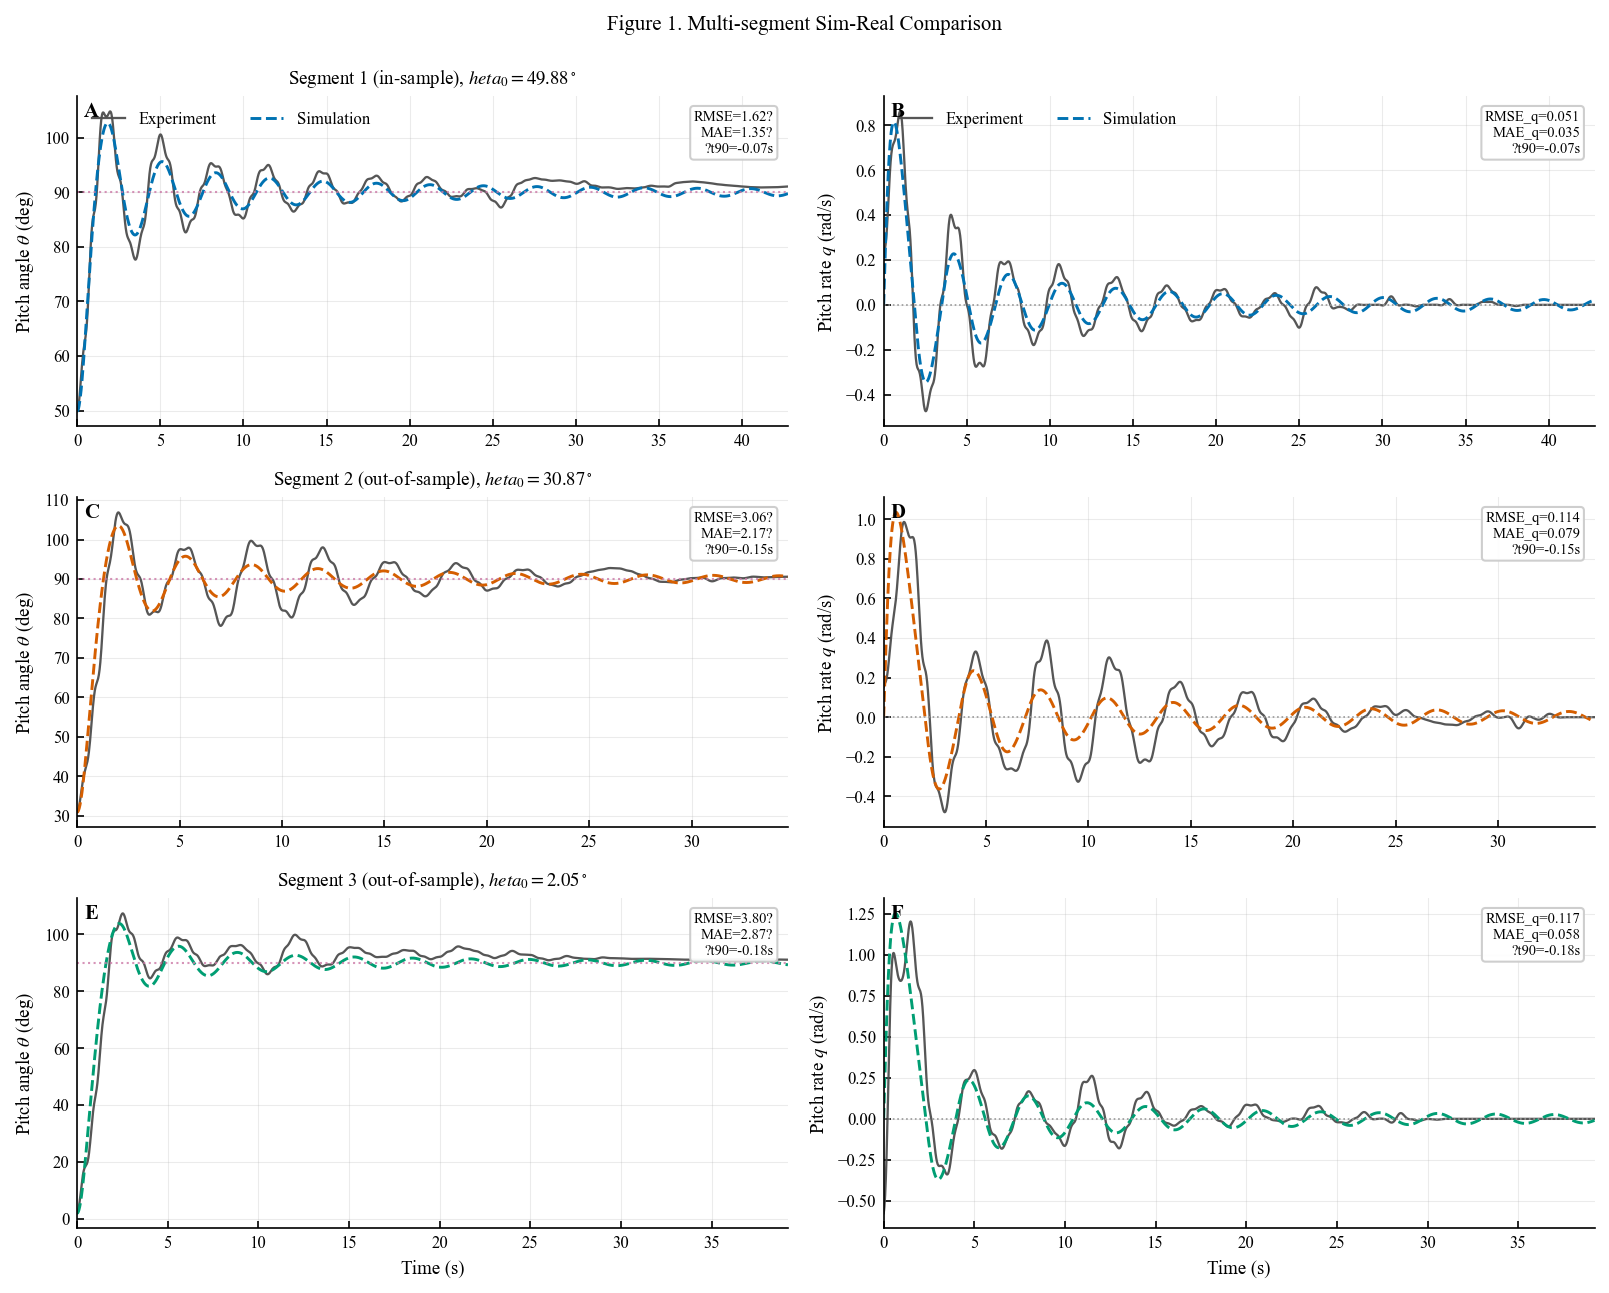

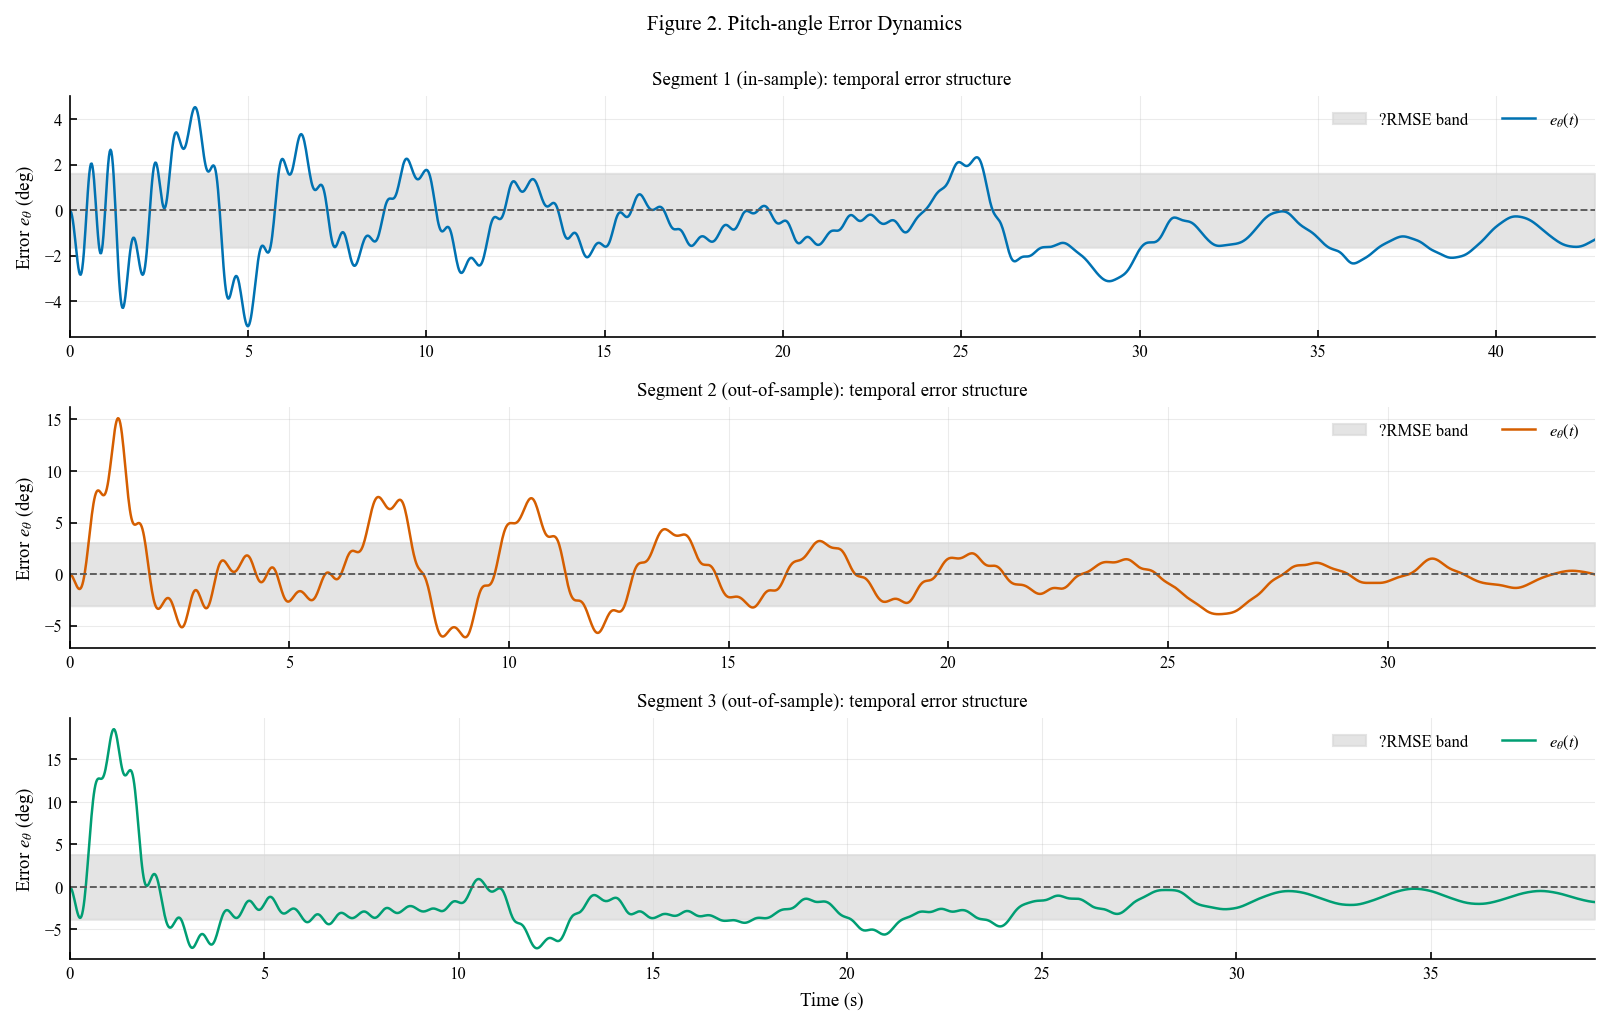

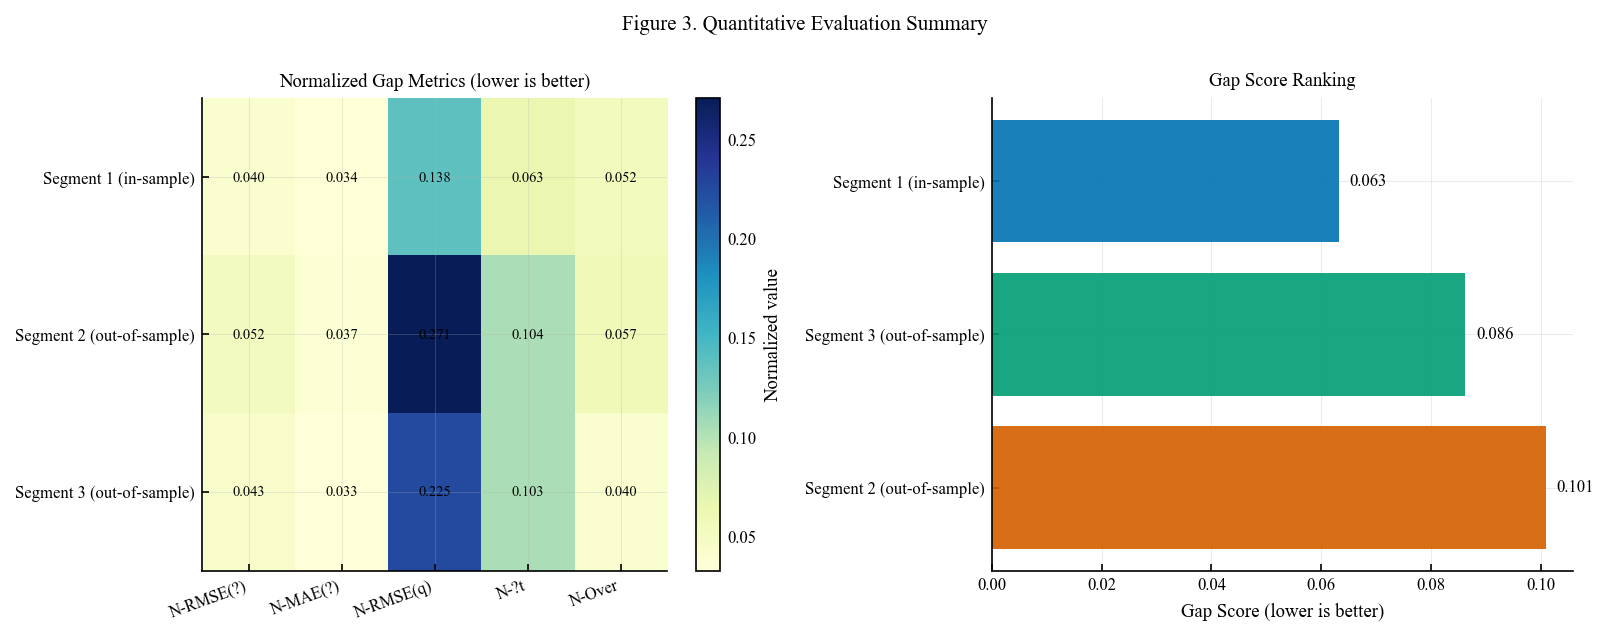

Ranked metrics by GapScore (lower is better):


,segment,validation,success,theta0_deg,duration_s,RMSE_theta_deg,MAE_theta_deg,MaxAbs_theta_deg,dt80_s,dt90_s,overshoot_error_deg,RMSE_q_rad_s,MAE_q_rad_s,N_RMSE_theta,N_MAE_theta,N_RMSE_q,N_t90,N_over,GapScore
0,Segment 1,in-sample,True,49.881382,42.752,1.621355,1.349061,5.094892,0.034454,-0.074923,-2.104333,0.050788,0.035241,0.040414,0.033627,0.137746,0.063350,0.052453,0.063167
2,Segment 3,out-of-sample,True,2.053130,39.209,3.800802,2.868716,18.549955,-0.288202,-0.184417,-3.556558,0.117251,0.058418,0.043217,0.032619,0.225045,0.103420,0.040440,0.086216
1,Segment 2,out-of-sample,True,30.871935,34.704,3.059165,2.165814,15.114242,-0.227923,-0.149868,-3.364369,0.114481,0.079134,0.051738,0.036629,0.270850,0.104218,0.056900,0.100927


In [5]:
# --- figures ---

plot_main_figure(runs_by_segment, metrics_df)
plot_error_figure(runs_by_segment, metrics_df)
plot_score_figure(metrics_df[metrics_df['success'] == True].copy())

print('Ranked metrics by GapScore (lower is better):')
display(metrics_df[metrics_df['success'] == True].sort_values('GapScore')[display_cols])
